# Stream-based machine learning pipeline

## OUTLINE: 
* Concept drift algorithms
* Hoeffding Adaptive Tree (Adaptive Random Forest takes too much time)
* Evaluation - Holdout, Prequential, "Real-world" (incremental)
* Note : same functionality can be achieved with higher performance in java based MOA (skmultiflow is a "child project" to MOA )

<img src="./images/stream_scenario.png" alt="drawing" width="1000"/>

### Concept drift

Concept drifts categories:

<img src="./images/concept_drifts.png" alt="drawing" width="500"/>

<small><small><small>
    
    [1] Gama, J., Žliobaitė, I., Bifet, A., Pechenizkiy, M., & Bouchachia, A. (2014). "A survey on concept drift adaptation." ACM computing surveys (CSUR), 46(4), 1-37.

</small></small></small>

## libraries

In [2]:
import numpy as np
import pandas as pd

#https://scikit-multiflow.github.io/scikit-multiflow/documentation.html#learning-methods
from skmultiflow.drift_detection import DDM
from skmultiflow.drift_detection.eddm import EDDM
from skmultiflow.drift_detection import PageHinkley
from skmultiflow.drift_detection.adwin import ADWIN
from skmultiflow.evaluation import EvaluateHoldout

from skmultiflow.meta import AdaptiveRandomForest
from skmultiflow.trees import HoeffdingTree
from skmultiflow.trees import HAT
from skmultiflow.evaluation import EvaluatePrequential

from skmultiflow.data import DataStream

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline
import glob

# Create a Workshop TEP dataset wih imbalanced classes for stream-based learning

In [10]:
dataset = pd.read_csv('workshop_dataset.csv',index_col=False)
dataset_testing = pd.read_csv('workshop_dataset_stream_testing.csv',index_col=False)
dataset_orig = pd.concat([dataset,dataset_testing]).reset_index(drop=True)
test_size_orig = len(dataset_testing)
training_size_orig = len(dataset)

dataset_shuffled = pd.read_csv('workshop_dataset.csv',index_col=False).sample(frac=1).reset_index(drop=True)
col_names = dataset.columns.tolist()
test_size = len(dataset)//10
training_size = len(dataset) - test_size

# 1. Concept Drift Detection

In [56]:
# magnitude of row vectors - concept drift detectors take as input single value not list/vector
#cd_data = dataset[dataset.columns[:-1]].apply(np.linalg.norm, axis=1).values
feature = 'xmeas_11'
cd_data = dataset[feature].values

In [57]:
adwin = ADWIN()
ddm = DDM()
eddm = EDDM()
ph = PageHinkley()

adwin_detected_changes = []
ddm_detected_changes = []
eddm_detected_changes = []
ph_detected_changes = []

for i in range(len(cd_data)):
    adwin.add_element(cd_data[i])
    ddm.add_element(cd_data[i])
    eddm.add_element(cd_data[i])
    ph.add_element(cd_data[i])
    if adwin.detected_change():
        adwin_detected_changes.append([i,cd_data[i]])
    if ddm.detected_change():
        ddm_detected_changes.append([i,cd_data[i]])
    if eddm.detected_change():
        eddm_detected_changes.append([i,cd_data[i]])
    if ph.detected_change():
        ph_detected_changes.append([i,cd_data[i]])
        
adwin_detected_changes = np.array(adwin_detected_changes)
ddm_detected_changes = np.array(ddm_detected_changes)
eddm_detected_changes = np.array(eddm_detected_changes)
ph_detected_changes = np.array(ph_detected_changes)

In [60]:
eddm_detected_changes

array([], dtype=float64)

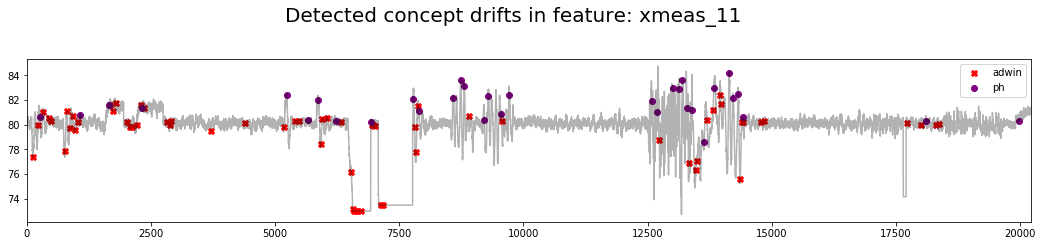

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(18, 3), facecolor='w', edgecolor='k')
fig.suptitle('Detected concept drifts in feature: '+ feature, size=20, y=1.12)
adwin_plot = ax.scatter(adwin_detected_changes[:,0], adwin_detected_changes[:,1], color='red', marker='X', label='adwin')
#ddm_plot = ax.scatter(ddm_detected_changes[:,0], ddm_detected_changes[:,1], color='yellow', marker='s', label='ddm')
#eddm_plot = ax.scatter(eddm_detected_changes[:,0], eddm_detected_changes[:,1], color='green', marker='D', label='eddm')
ph_plot = ax.scatter(ph_detected_changes[:,0], ph_detected_changes[:,1], color='purple', marker='o', label='ph')
feature_plot = ax.plot(cd_data, color = 'black', alpha=0.3)
ax.set_xlim([0,len(cd_data)])
ax.legend()

# 2. Classification pipeline

2.1 Holdout - follows batch machine learning logic, i.e. train incremetanlly models and test it on test dataset  
2.2 Prequential - test-then-train  
2.3 Real-world scenarios - model is incrementally trained and then incremetally tested by comparing predicted labels to ground truth  

## 2.1. Holdout evaluation - without shuffling

In [11]:
HAT.reset()
#HAT = HAT()

samples = dataset_orig.drop(columns=['fault_id'])
labels  = dataset_orig['fault_id'].to_frame()

stream = DataStream(data = samples, y = labels)
stream.prepare_for_use()

evaluator = EvaluateHoldout(max_samples=100000,
                            max_time=7200,
                            n_wait=100,                            
                            batch_size=100,
                            test_size=training_size_orig,
                            output_file='HAT_holdout_noshuffling.csv',
                            metrics=['precision','recall','f1'])
evaluator.evaluate(stream=stream, model=[HAT], model_names=['HAT'])

Holdout Evaluation
Evaluating 1 target(s).
Separating 20232 holdout samples.
Evaluating...
 #################### [100%] [5749.74s]
Processed samples: 31732
Mean performance:
HAT - Precision: 1.0000
HAT - Recall: 0.4075
HAT - F1 score: 0.5790


[HAT(binary_split=False, grace_period=200, leaf_prediction='nba',
     max_byte_size=33554432, memory_estimate_period=1000000, nb_threshold=0,
     no_preprune=False, nominal_attributes=None, remove_poor_atts=False,
     split_confidence=1e-07, split_criterion='info_gain',
     stop_mem_management=False, tie_threshold=0.05)]

## 2.2. Holdout evaluation - with shuffling

In [4]:
HAT.reset()
samples = dataset_shuffled.drop(columns=['fault_id'])
labels  = dataset_shuffled['fault_id'].to_frame()

stream = DataStream(data = samples, y = labels)
stream.prepare_for_use()

evaluator = EvaluateHoldout(max_samples=100000,
                            max_time=7200,
                            n_wait=100,                            
                            batch_size=100,
                            test_size=training_size,
                            output_file='HAT_holdout.csv',
                            metrics=['precision','recall','f1'])
evaluator.evaluate(stream=stream, model=[HAT], model_names=['HAT'])

Holdout Evaluation
Evaluating 1 target(s).
Separating 18209 holdout samples.
Evaluating...
 #################### [100%] [2358.34s]
Processed samples: 20309
Mean performance:
HAT - Precision: 0.9990
HAT - Recall: 0.9983
HAT - F1 score: 0.9987


[HAT(binary_split=False, grace_period=200, leaf_prediction='nba',
     max_byte_size=33554432, memory_estimate_period=1000000, nb_threshold=0,
     no_preprune=False, nominal_attributes=None, remove_poor_atts=False,
     split_confidence=1e-07, split_criterion='info_gain',
     stop_mem_management=False, tie_threshold=0.05)]

## 2.3. Prequential evaluation

In [5]:
HAT.reset()
evaluator = EvaluatePrequential(n_wait=100, 
                                batch_size=100, 
                                pretrain_size=100, 
                                output_file='HAT_prequential.csv',
                                metrics=['precision','recall','f1'])
evaluator.evaluate(stream=stream, model=HAT, model_names=['HAT'])

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 100 sample(s).
Evaluating...
 #################### [100%] [361.08s]
Processed samples: 20300
Mean performance:
HAT - Precision: 0.9634
HAT - Recall: 0.9351
HAT - F1 score: 0.9490


[HAT(binary_split=False, grace_period=200, leaf_prediction='nba',
     max_byte_size=33554432, memory_estimate_period=1000000, nb_threshold=0,
     no_preprune=False, nominal_attributes=None, remove_poor_atts=False,
     split_confidence=1e-07, split_criterion='info_gain',
     stop_mem_management=False, tie_threshold=0.05)]

In [75]:
# skmultiflow saves results to file with leading 5 lines containing configuraiton of evaluation, learner etc
# skmultiflow also did not evaluate last 200 samples
# for the sake of comparisson we shrink the MOA results
# accuracy in MOA is in % and in skmultiflow fraction
HAT_holdout_results = pd.read_csv('HAT_holdout.csv',skiprows=[0,1,2,3,4],index_col='id')
HAT_prequential_results = pd.read_csv('HAT_prequential.csv',skiprows=[0,1,2,3,4],index_col='id')

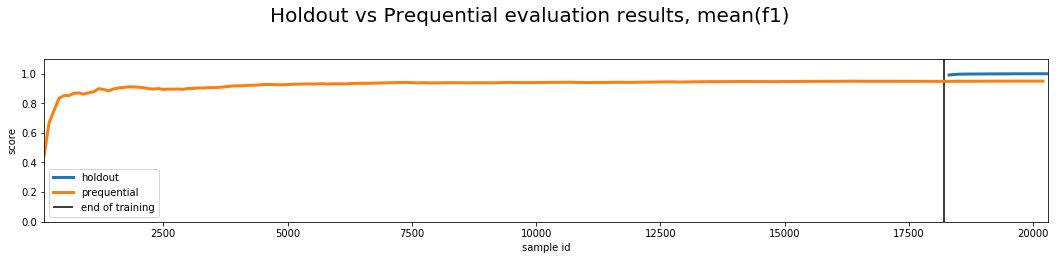

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(18, 3), facecolor='w', edgecolor='k')
fig.suptitle('Holdout vs Prequential evaluation results, mean(f1)', size=20, y=1.12)
HAT_holdout_results['mean_f1_[HAT]'].plot(ax=ax, label='holdout', linewidth=3)
HAT_prequential_results['mean_f1_[HAT]'].plot(ax=ax, label='prequential', linewidth=3)
ax.vlines(training_size,0,1.5, label='end of training')
ax.set_ylim([0,1.1])
ax.set_xlabel('sample id')
ax.set_ylabel('score')
ax.legend()

## 2.4. Real-world scenario

### 2.4.1. Incremental approach

#### 2.4.1.1. Train

In [67]:
HAT.reset()

samples_train = dataset_shuffled.drop(columns=['fault_id']).values[:training_size]
labels_train  = dataset_shuffled['fault_id'].to_frame().values.flatten()[:training_size]

stream_train = DataStream(data=samples_train, y=labels_train)
stream_train.prepare_for_use()

for sample in range(len(labels_train)):
    X, Y = stream_train.next_sample()
    HAT.partial_fit(X, Y)

#### 2.4.1.2. Test

In [68]:
samples_test = dataset_shuffled.drop(columns=['fault_id']).values[training_size:]
labels_test  = dataset_shuffled['fault_id'].to_frame().values.flatten()[training_size:]

stream_test = DataStream(data = samples_test, y = labels_test)
stream_test.prepare_for_use()

labels_test_predicted = []
for sample in range(len(labels_test)):
    X, Y = stream_test.next_sample()
    Y_pred = HAT.predict(X)
    labels_test_predicted.extend(HAT.predict(X))
    
print('Classification report :\n' + str(classification_report(labels_test, labels_test_predicted)))

Classification report :
              precision    recall  f1-score   support

           0       0.07      0.25      0.11        12
           1       0.91      0.72      0.80       141
           2       0.99      0.88      0.93       121
           3       0.25      0.51      0.34       109
           4       0.88      0.88      0.88       128
           5       0.27      0.14      0.18       132
           6       1.00      0.88      0.93       120
           7       1.00      0.86      0.92        71
           8       0.63      0.59      0.61       140
           9       0.22      0.37      0.28        95
          10       0.56      0.39      0.46       162
          11       0.67      0.67      0.67        24
          12       0.68      0.62      0.65       115
          13       0.60      0.60      0.60        78
          14       0.82      0.80      0.81       120
          15       0.21      0.18      0.19        84
          16       0.14      0.20      0.16        41
   

### 2.4.2. Bulk approach

In [70]:
HAT.reset()
HAT.fit(samples_train,labels_train.flatten())
labels_test_predicted = HAT.predict(samples_test)
print('Classification report :\n' + str(classification_report(labels_test, labels_test_predicted)))

Classification report :
              precision    recall  f1-score   support

           0       0.07      0.25      0.11        12
           1       0.91      0.72      0.80       141
           2       0.99      0.88      0.93       121
           3       0.25      0.51      0.34       109
           4       0.88      0.88      0.88       128
           5       0.27      0.14      0.18       132
           6       1.00      0.88      0.93       120
           7       1.00      0.86      0.92        71
           8       0.63      0.59      0.61       140
           9       0.22      0.37      0.28        95
          10       0.56      0.39      0.46       162
          11       0.67      0.67      0.67        24
          12       0.68      0.62      0.65       115
          13       0.60      0.60      0.60        78
          14       0.82      0.80      0.81       120
          15       0.21      0.18      0.19        84
          16       0.14      0.20      0.16        41
   